In [ ]:
library(Seurat)
library(sctransform)
library(tidyverse)
library(repr)
library(patchwork)
library(biomaRt)
library(Matrix)

library(DoubletFinder)

library(future)
plan("multisession", workers = 10)
options(future.globals.maxSize= 3e+09)
options(Seurat.object.assay.version = "v3")

# load data

## batch1

In [33]:
sample_seq=c("17T4.176","18T3.177","18T4.178",
                    "132T1.179","151T4.181")

In [34]:
samples=str_split_fixed(sample_seq,"\\.",2)[,1]
samples

[1] "17T4"  "18T3"  "18T4"  "132T1" "151T4"

In [35]:
#/data2/xiangwei/projects/zhaolian_old/cellrangerMulti/run/
batch1Files = str_c("/data2/xiangwei/projects/zhaolian_old/cellrangerMulti/run/",
              samples,
              "/outs/per_sample_outs/",
              samples,
              "/count/sample_filtered_feature_bc_matrix",sep = "")
names(batch1Files)=samples
batch1Files[1]

17T4 
"/data2/xiangwei/projects/zhaolian_old/cellrangerMulti/run/17T4/outs/per_sample_outs/17T4/count/sample_filtered_feature_bc_matrix"

## batch2

In [36]:
sample_seq=c("142T2.234","142T54.236","148T1.238","148T3.239")

In [37]:
samples=str_split_fixed(sample_seq,"\\.",2)[,1]
samples

[1] "142T2"  "142T54" "148T1"  "148T3"

In [38]:
batch2Files = str_c("/data2/xiangwei/projects/zhaolian/01cellrangerMulti/batch2/run/",
              samples,
              "/outs/per_sample_outs/",
              samples,
              "/count/sample_filtered_feature_bc_matrix",sep = "")
names(batch2Files)=samples
batch2Files[1]

142T2 
"/data2/xiangwei/projects/zhaolian/01cellrangerMulti/batch2/run/142T2/outs/per_sample_outs/142T2/count/sample_filtered_feature_bc_matrix"

In [39]:
files=c(batch1Files,batch2Files)

In [40]:
rawCounts=Read10X(data.dir = files)

In [ ]:
# create seurat object
scdata=CreateSeuratObject(rawCounts,project = "mouse")

In [44]:
table(scdata$orig.ident)


 132T1  142T2 142T54  148T1  148T3  151T4   17T4   18T3   18T4 
  5683   6937   7245   8130   6061   6500  11051   6356   2516 

## batch1&2 countmatrix

In [45]:
zhaolianCountsMatrix=as.data.frame(scdata[["RNA"]]$counts)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 14.5 GiB”


## WT countmatrix

In [46]:
AOMdata=readRDS("/data2/xiangwei/projects/zhaolian_old/AOM_DSS_APC/results/AOMrawcountMatrix")

In [47]:
cellBarcode=colnames(AOMdata)
WTbarcode=str_detect(cellBarcode,"^WT")
WTcountsMatrix=AOMdata[,WTbarcode]

In [ ]:
sharedGenes=intersect(rownames(zhaolianCountsMatrix),rownames(WTcountsMatrix))
length(sharedGenes)
sharedGenes[1:10]
dim(WTcountsMatrix)

# mergedata

In [49]:
zhaolianTibble=zhaolianCountsMatrix%>%rownames_to_column(var="geneID")%>%as_tibble()
WTtibble=WTcountsMatrix%>%rownames_to_column(var="geneID")%>%as_tibble()

In [50]:
mergeCounts=WTtibble%>%inner_join(zhaolianTibble,by="geneID")
dim(mergeCounts)

[1] 27738 63772

In [51]:
mergeCountsMatrix=mergeCounts%>%as.data.frame()%>%column_to_rownames(var="geneID")

In [53]:
saveRDS(mergeCountsMatrix,"results/rawCountsMatrix.rds")

In [54]:
mergeCountsMatrix = Matrix(as.matrix(mergeCountsMatrix) , sparse=TRUE)

# create seuratobject

In [55]:
scdata=CreateSeuratObject(mergeCountsMatrix,min.cells = 3,project = "IBD_WT")
scdata
head(scdata@meta.data)

An object of class Seurat 
25527 features across 63771 samples within 1 assay 
Active assay: RNA (25527 features, 0 variable features)
 2 layers present: counts, data

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
WT_1.bcHTXJ,WT,5633,2155
WT_1.bcHGRE,WT,10486,3854
WT_1.bcHIFA,WT,9426,3134
WT_1.bcFSFT,WT,3250,1590
WT_1.bcHFJN,WT,7899,2743
WT_1.bcHHLG,WT,8083,3062


In [56]:
table(scdata$orig.ident)


 132T1  142T2 142T54  148T1  148T3  151T4   17T4   18T3   18T4     WT 
  5683   6937   7245   8130   6061   6500  11051   6356   2516   3292 

## change sample name

In [57]:
sampleID=scdata$orig.ident

In [58]:
sampleID=factor(sampleID,labels = c('132_T1','142_T2','142_T5-4','148_T1','148_T3','151_T4',
                                    '17_T4','18_T3','18_T4','WT'))

In [59]:
cellbarcode=colnames(scdata)
WT1=str_detect(cellbarcode,"WT_1")
WT2=str_detect(cellbarcode,"WT_2")

In [ ]:
sampleID=as.character(sampleID)

In [61]:
sampleID[WT1]="WT1"
sampleID[WT2]="WT2"
scdata[["sampleID"]]=sampleID
table(scdata$sampleID)


  132_T1   142_T2 142_T5-4   148_T1   148_T3   151_T4    17_T4    18_T3 
    5683     6937     7245     8130     6061     6500    11051     6356 
   18_T4      WT1      WT2 
    2516     1698     1594 

# MT

In [62]:
scdata[["percent.mt"]] = PercentageFeatureSet(scdata, pattern = "^mt-")
#scdata[["percent.ribo"]] = PercentageFeatureSet(scdata, pattern = "^Rp[sl]")

# QC

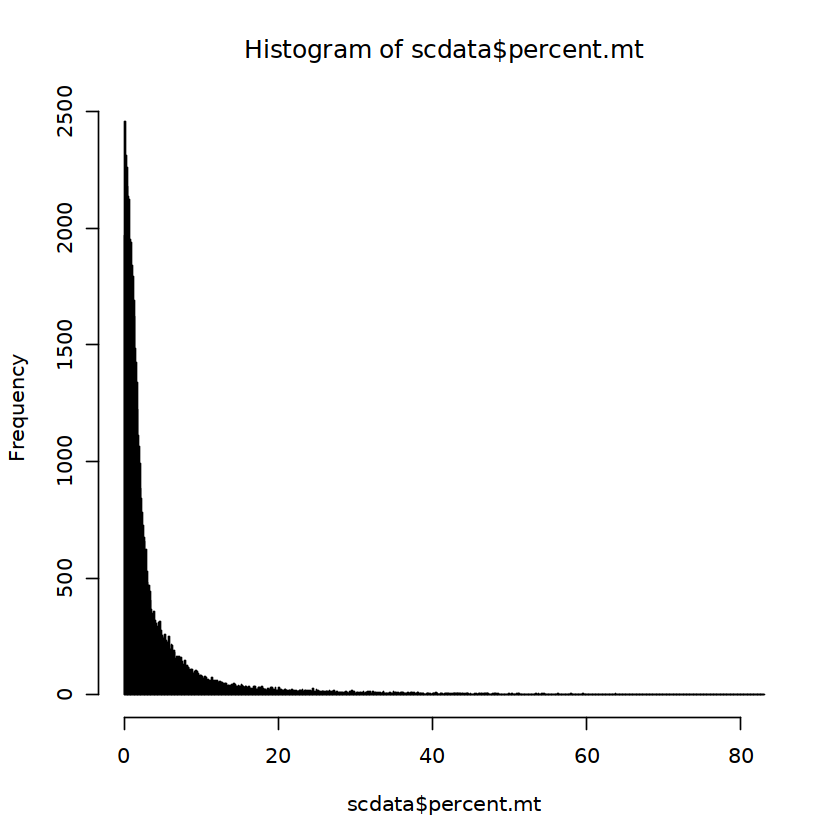

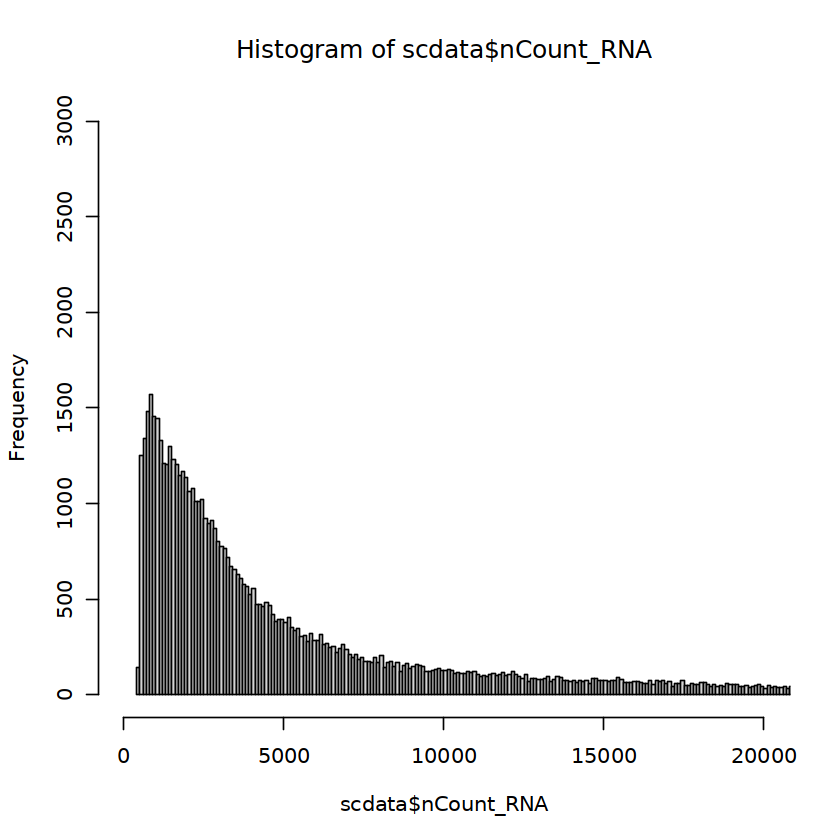

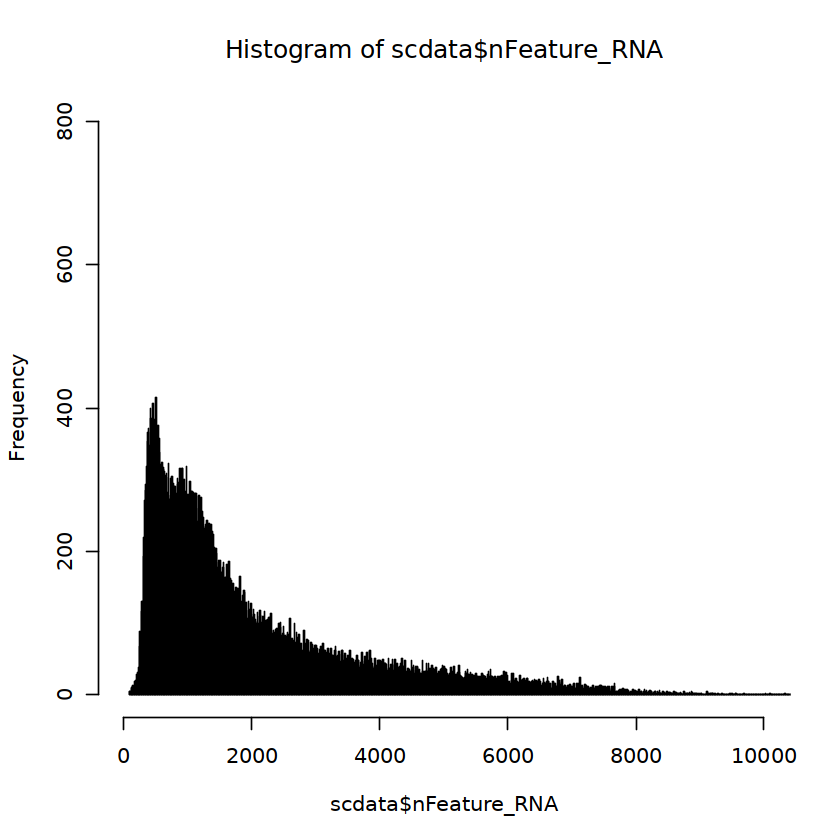

In [63]:
pct.mt=hist(scdata$percent.mt,breaks = 1000)
nCountplot=hist(scdata$nCount_RNA,breaks = 2000,xlim = c(0,20000),ylim = c(0,3000))
nFeatureplot=hist(scdata$nFeature_RNA,breaks = 1000,xlim = c(0,10000),ylim = c(0,800))

In [64]:
min(scdata$nCount_RNA)
min(scdata$nFeature_RNA)

[1] 485

[1] 80

In [ ]:
# filter
scFiltered = subset(scdata, subset = percent.mt < 15  & nFeature_RNA > 500
                #nFeature_RNA > 300& nFeature_RNA < 7000 & percent.mt < 10 & percent.HB < 3 & nCount_RNA < 100000
               )

# cycle circle

In [66]:
# convert mouse to human gene names
hg_musg=read.table("/data2/xiangwei/xiangwei/ref/biomart/mart_export.txt",header = T,sep = "\t")

In [67]:
# human cellcycle gene
g2m.genes = cc.genes$g2m.genes
s.genes = cc.genes$s.genes

In [68]:
# match human cycle genes with hg_musg data
length(g2m.genes)
length(intersect(g2m.genes,hg_musg$Gene.name))
# match human s with mouse
length(s.genes)
length(intersect(s.genes,hg_musg$Gene.name))

[1] 54

[1] 52

[1] 43

[1] 42

In [ ]:
# get mouse g2m gene
mus.g2m=as.data.frame(hg_musg) %>% filter(hg_musg$Gene.name %in% g2m.genes) %>% 
  filter(str_starts(.$Mouse.gene.name,"[A-Z]"))%>% 
  distinct(Gene.name,.keep_all = T)
dim(mus.g2m)
mus.g2m=mus.g2m$Mouse.gene.name
mus.g2m

In [ ]:
# get mouse s gene
mus.s=as.data.frame(hg_musg) %>% filter(hg_musg$Gene.name %in% s.genes) %>% 
  filter(str_starts(.$Mouse.gene.name,"[A-Z]"))%>%
  distinct(Gene.name,.keep_all = T)
dim(mus.s)
mus.s=mus.s$Mouse.gene.name
mus.s

In [71]:
#merge
mus.cellcycle.genes=c(mus.g2m,mus.s)
length(mus.cellcycle.genes)

[1] 91

In [72]:
#rownames(scFiltered) include all 91 genes 
length(intersect(mus.cellcycle.genes,rownames(scFiltered)))

[1] 91

In [73]:
# calculate cell cycle score
scFiltered=scFiltered %>% NormalizeData(verbose = FALSE) %>% ScaleData(verbose = FALSE,features = mus.cellcycle.genes)

In [ ]:
scFiltered= CellCycleScoring(scFiltered, s.features = mus.s, g2m.features = mus.g2m)
scFiltered = RunPCA(scFiltered, features = c(mus.s, mus.g2m),verbose = F)

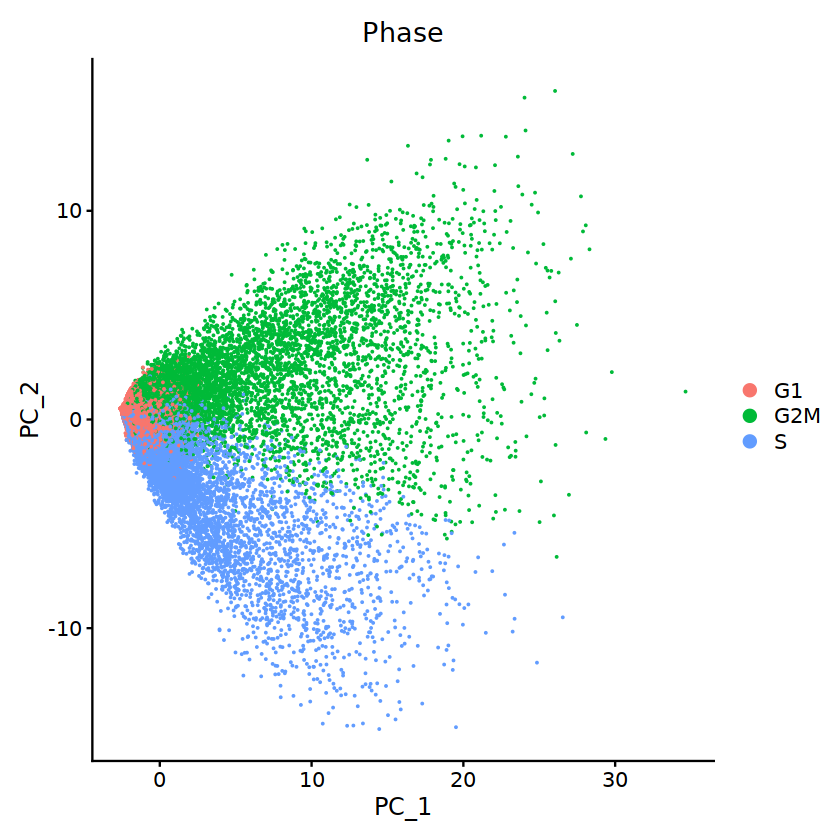

In [75]:
DimPlot(scFiltered, reduction = "pca", group.by = "Phase")

In [76]:
scFiltered=DietSeurat(scFiltered,assays = "RNA")

In [77]:
head(scFiltered@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sampleID,percent.mt,S.Score,G2M.Score,Phase
,<fct>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
WT_1.bcHTXJ,WT,5633,2155,WT1,3.586011,-0.0003662736,-0.08109041,G1
WT_1.bcHGRE,WT,10486,3854,WT1,5.912645,0.2258984989,0.23380689,G2M
WT_1.bcHIFA,WT,9426,3134,WT1,6.354763,0.0071937194,0.01036396,G2M
WT_1.bcFSFT,WT,3250,1590,WT1,5.353846,-0.0758368609,-0.01989292,G1
WT_1.bcHFJN,WT,7899,2743,WT1,7.887074,-0.0376825481,-0.05862912,G1
WT_1.bcHHLG,WT,8083,3062,WT1,5.876531,-0.0700284584,-0.08521747,G1


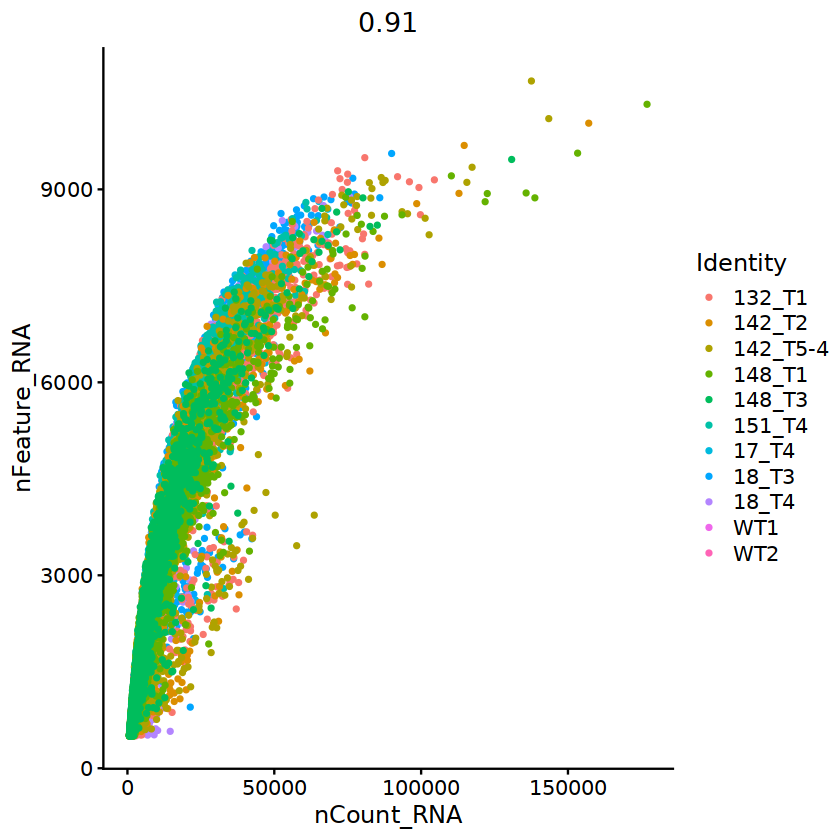

In [82]:
FeatureScatter(scFiltered, feature1 = "nCount_RNA", feature2 = "nFeature_RNA",group.by ="sampleID")

# doubletFinder

In [ ]:
sampleList=SplitObject(scFiltered,split.by = "sampleID")

for (i in seq_along(sampleList)) {
sample=sampleList[[i]]
## Pre-process Seurat object (sctransform)
sample=SCTransform(sample, vst.flavor = "v2", verbose = FALSE) %>%
    RunPCA(verbose = FALSE) %>%
    RunUMAP(dims = 1:50,verbose = FALSE) %>%
    FindNeighbors(reduction = "pca",dims = 1:50,verbose = FALSE) %>%
    FindClusters(resolution = 0.3, verbose = FALSE)
## pK Identification 
sweep.res.list = paramSweep_v3(sample, PCs = 1:30, sct = T)
sweep.stats = summarizeSweep(sweep.res.list, GT = FALSE)
bcmvn = find.pK(sweep.stats)
opt_pK = as.numeric(as.vector(bcmvn$pK[which.max(bcmvn$BCmetric)]))


## Homotypic Doublet Proportion Estimate
doubletRate=ncol(sample)*8*1e-6
homotypic.prop = modelHomotypic(sample$seurat_clusters)           
nExp_poi = round(doubletRate*nrow(sample)) 
nExp_poi.adj = round(nExp_poi*(1-homotypic.prop))
## Run DoubletFinder
sample <- doubletFinder_v3(seu = sample, 
                           PCs = 1:30,
                           pN=0.25,
                           pK = opt_pK,
                           nExp = nExp_poi.adj,
                           sct=T)
## change column name
colnames(sample@meta.data)[ncol(sample@meta.data)-1] = "pANN"
colnames(sample@meta.data)[ncol(sample@meta.data)] = "DF.classifications"
## get results
sampleList[[i]]=sample
}

In [ ]:
scdataDF=merge(sampleList[[1]],y=c(str_c("sampleList[[",2:length(sampleList),"]],",collapse = "")))

In [ ]:
scdataDF[["S.Score"]]=NULL
scdataDF[["G2M.Score"]]=NULL
scdataDF[["nCount_SCT"]]=NULL
scdataDF[["nFeature_SCT"]]=NULL
scdataDF[["SCT_snn_res.0.3"]]=NULL
scdataDF[["seurat_clusters"]]=NULL
scdataDF[["pANN"]]=NULL